In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
import os
import pandas as pd
import torch
from dataset_preprocessing import TokenInfo
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import itertools
import pandas as pd
from tqdm import tqdm

## Importances

In [4]:
def get_importances():
    # print("this is wrong")
    dir = "./new_importances_data"
    imp_files = os.listdir(dir)
    imp_files = [file for file in imp_files if file.endswith(".pkl")]
    importances = {}
    for imp_file in tqdm(imp_files):
        importances.update(pd.read_pickle(f"{dir}/{imp_file}"))
    return importances

In [5]:
# imps = get_importances()

In [6]:
def get_avg_imporances(importances):
    avg_imps = [torch.zeros_like(imp) for imp in list(importances.values())[0]]
    for token, imps in tqdm(importances.items()):
        for i, layer_imps in enumerate(imps):
            avg_imps[i] += layer_imps / len(importances)
    # TODO think harder about averaging method
    return avg_imps

In [7]:
# avg_importances = get_avg_imporances(imps)

In [8]:
# pd.to_pickle(avg_importances, "./avg_importances.pkl")

In [9]:
avg_importances = pd.read_pickle("./avg_importances.pkl")

In [10]:
len(avg_importances)

24

## Model

In [11]:
model_id = "microsoft/phi-1_5"
model_revision = "349cf8b5e81fd5f791d1740da5de1313a0419bbd" # latest as of feb 1st

In [12]:
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)

In [13]:
vocab = tokenizer.get_vocab()
len(vocab)

50295

In [14]:
# tokenizer.decode(token_info.get_prefixes(top_tokens[1000][0], 9, 10)[0])

In [15]:
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    revision=model_revision,
    trust_remote_code=True,
    # be careful with this?
    # torch_dtype=torch.float16,
    # attn_implementation="flash_attention_2",
)

## Prune Model

In [16]:
from prunners import prune_mlps_individually
from importances import get_mlps

In [17]:
mlps = get_mlps(model)

In [18]:
len(mlps), len(avg_importances)

(24, 24)

In [19]:
avg_importances = dict(zip(mlps, avg_importances))

In [20]:
prune_mlps_individually(avg_importances, 0.2)

In [21]:
model

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2048)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-23): 24 x PhiDecoderLayer(
        (self_attn): PhiAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (k_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (v_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (dense): Linear(in_features=2048, out_features=2048, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear(in_features=2048, out_features=6554, bias=True)
          (fc2): Linear(in_features=6554, out_features=2048, bias=True)
        )
        (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.0, inplace=False)
      )
    )
    (final_layernorm): LayerNorm((2048,), e

## Metric Callback

In [22]:
from transformers import TrainerCallback

In [23]:
from evaluation import evaluate_on_nlp_tasks

In [24]:
class AccEvalCallback(TrainerCallback):
    def __init__(self):
        super().__init__()
        self.last_step=-1

    def on_evaluate(self, args, state, control, model, **kwargs):
        if state.global_step == self.last_step:
            return
        self.last_step = state.global_step
        train = model.training
        model.eval()
        with torch.no_grad():
            os.environ["TQDM_DISABLE"] = "1"
            eval_res = evaluate_on_nlp_tasks(model, tokenizer, limit=100, do_shuffle=True)["results"]
            # import pdb; pdb.set_trace()
            eval_res = {k:v["acc,none"] for k,v in eval_res.items()}
            for k, v in eval_res.items():
                state.log_history.append(
                    {
                        k:v,
                        "epoch":state.epoch,
                        "step":state.global_step,
                    }
                )
            del os.environ['TQDM_DISABLE']
            print(eval_res)
        model.train(train)

In [25]:
class SaveCallback(TrainerCallback):
    def __init__(self, save_path):
        super().__init__()
        self.save_path = save_path
        self.last_step=-1

    def on_evaluate(self, args, state, control, model, **kwargs):
        if state.global_step == self.last_step:
            return
        self.last_step = state.global_step
        try:
            torch.save(model.state_dict(), self.save_path)
        except Exception as e:
            print(f"error saving {e}")

## Train model

In [26]:
from peft import LoraConfig, PeftConfig
import transformers

In [27]:
from post_training import get_lora_config, get_training_arguments
from dataset import get_baseline_dataset
from trl import SFTTrainer

In [28]:
lora_config = get_lora_config()
training_arguments = get_training_arguments("./tmp")

In [29]:
model.cuda();

In [30]:
model.config.use_cache = False
model.config.pretraining_tp = 1
model.gradient_checkpointing_enable()

In [31]:
dataset = get_baseline_dataset()
train_data, eval_data = dataset["train"], dataset["test"]

reading pickle


In [32]:
tokenizer.pad_token = tokenizer.eos_token
training_arguments.save_strategy="no"
training_arguments.eval_steps = 100

In [33]:
save_path = "./tmp/llmpruner_style_20_state_dict"
callbacks = [AccEvalCallback(), SaveCallback(save_path)]

In [34]:
trainer = SFTTrainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=eval_data,
    peft_config=lora_config,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=False,
    dataset_text_field="text",
    max_seq_length=1024, # tweak this
    # TODO: think harder about the datacollator
    # data_collator=transformers.DataCollatorForSeq2Seq(
    #     tokenizer, pad_to_multiple_of=8, return_tensors="pt", padding=True
    # ),
    callbacks=callbacks,
)

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

2024-03-10:05:16:46,329 WARNING  [logging.py:61] Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


## Before training performance evaluation

In [ ]:
from evaluation import evaluate_on_nlp_tasks

In [ ]:
trainer.evaluate()

In [ ]:
model.eval()

In [ ]:
eval_res_orig = evaluate_on_nlp_tasks(model, tokenizer, limit=1000, bootstrap_iters=1000, do_shuffle=False)

In [ ]:
eval_res_orig["results"]

In [ ]:
eval_res = evaluate_on_nlp_tasks(model, tokenizer, limit=1000, bootstrap_iters=1000, do_shuffle=True)

In [ ]:
eval_res["results"]

## Training

In [ ]:
model.train()

In [36]:
train_res = trainer.train()

Step,Training Loss,Validation Loss
100,3.212200,3.189142
200,3.168100,3.143970
300,3.137300,3.130597
400,3.193800,3.123451
500,3.079400,3.118901
600,3.146500,3.115010
700,3.094300,3.112337
800,3.122800,3.109700
900,3.158000,3.108447
1000,3.081300,3.107401


will shuffle dataset


/opt/conda/lib/python3.10/site-packages/datasets/load.py:1461: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|███████████████████████| 1000/1000 [00:30<00:00, 32.27it/s]


{'hellaswag': 0.4, 'piqa': 0.73, 'boolq': 0.6, 'winogrande': 0.73}
will shuffle dataset


/opt/conda/lib/python3.10/site-packages/datasets/load.py:1461: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|███████████████████████| 1000/1000 [00:31<00:00, 31.76it/s]


{'hellaswag': 0.41, 'piqa': 0.74, 'boolq': 0.6, 'winogrande': 0.73}
will shuffle dataset


/opt/conda/lib/python3.10/site-packages/datasets/load.py:1461: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|███████████████████████| 1000/1000 [00:31<00:00, 31.95it/s]


{'hellaswag': 0.41, 'piqa': 0.74, 'boolq': 0.6, 'winogrande': 0.74}
will shuffle dataset


/opt/conda/lib/python3.10/site-packages/datasets/load.py:1461: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|███████████████████████| 1000/1000 [00:30<00:00, 32.27it/s]


{'hellaswag': 0.4, 'piqa': 0.74, 'boolq': 0.6, 'winogrande': 0.72}
will shuffle dataset


/opt/conda/lib/python3.10/site-packages/datasets/load.py:1461: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
 83%|███████████████████▉    | 831/1000 [00:25<00:05, 33.34it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



will shuffle dataset


/opt/conda/lib/python3.10/site-packages/datasets/load.py:1461: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|███████████████████████| 1000/1000 [00:30<00:00, 32.62it/s]


{'hellaswag': 0.41, 'piqa': 0.74, 'boolq': 0.6, 'winogrande': 0.7}
will shuffle dataset


/opt/conda/lib/python3.10/site-packages/datasets/load.py:1461: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|███████████████████████| 1000/1000 [00:31<00:00, 32.16it/s]


{'hellaswag': 0.4, 'piqa': 0.75, 'boolq': 0.61, 'winogrande': 0.68}
will shuffle dataset


/opt/conda/lib/python3.10/site-packages/datasets/load.py:1461: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|███████████████████████| 1000/1000 [00:31<00:00, 31.40it/s]


{'hellaswag': 0.41, 'piqa': 0.74, 'boolq': 0.62, 'winogrande': 0.7}
will shuffle dataset


/opt/conda/lib/python3.10/site-packages/datasets/load.py:1461: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|███████████████████████| 1000/1000 [00:31<00:00, 32.20it/s]


{'hellaswag': 0.4, 'piqa': 0.75, 'boolq': 0.62, 'winogrande': 0.7}
will shuffle dataset


/opt/conda/lib/python3.10/site-packages/datasets/load.py:1461: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|███████████████████████| 1000/1000 [00:31<00:00, 32.10it/s]


{'hellaswag': 0.4, 'piqa': 0.74, 'boolq': 0.62, 'winogrande': 0.7}
will shuffle dataset


/opt/conda/lib/python3.10/site-packages/datasets/load.py:1461: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|███████████████████████| 1000/1000 [00:30<00:00, 32.47it/s]


{'hellaswag': 0.4, 'piqa': 0.75, 'boolq': 0.62, 'winogrande': 0.69}


In [37]:
pd.to_pickle(trainer.state, "./tmp/llmpruner_style_20.pkl")

In [38]:
trainer_state = trainer.state
pd.DataFrame(trainer_state.log_history).tail()

,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,hellaswag,piqa,boolq,winogrande,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
243,3.0831,0.343519,2.298851e-06,1.96,1630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
244,3.0838,0.363677,1.660281e-06,1.97,1640,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,3.1203,0.336638,1.021711e-06,1.98,1650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,3.1403,0.328405,3.831418e-07,1.99,1660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,NaN,NaN,NaN,2.00,1666,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19715.7721,5.072,0.085,3.479417e+17,3.136975


## Post-training performance evaluation:

In [55]:
valid_loss = pd.DataFrame(trainer_state.log_history)[["step", "eval_loss"]].set_index("step").dropna()

In [56]:
valid_loss

,eval_loss
step,
100,3.189142
200,3.143970
300,3.130597
400,3.123451
500,3.118901
600,3.115010
700,3.112337
800,3.109700
900,3.108447


<Axes: xlabel='step'>

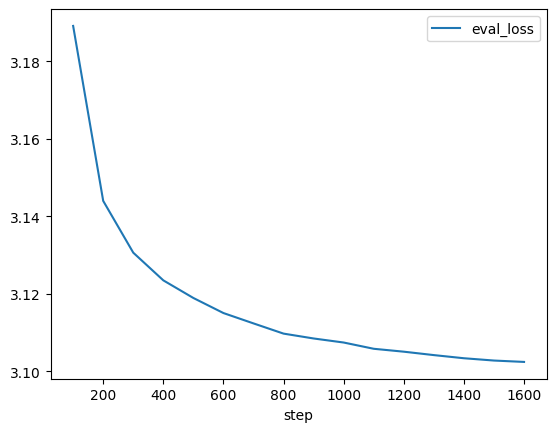

In [57]:
valid_loss.plot()

In [39]:
from evaluation import evaluate_on_nlp_tasks

In [40]:
model.eval();

In [41]:
with torch.no_grad():
    eval_res = evaluate_on_nlp_tasks(model, tokenizer, limit=300, do_shuffle=True)

will shuffle dataset


/opt/conda/lib/python3.10/site-packages/datasets/load.py:1461: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|███████████████████████| 3000/3000 [01:27<00:00, 34.14it/s]


In [42]:
eval_res["results"]

{'hellaswag': {'acc,none': 0.44333333333333336,
  'acc_norm,none': 0.5466666666666666,
  'alias': 'hellaswag'},
 'piqa': {'acc,none': 0.7533333333333333,
  'acc_norm,none': 0.75,
  'alias': 'piqa'},
 'boolq': {'acc,none': 0.6466666666666666, 'alias': 'boolq'},
 'winogrande': {'acc,none': 0.68, 'alias': 'winogrande'}}

In [43]:
eval_res_orig = evaluate_on_nlp_tasks(model, tokenizer, limit=1000, bootstrap_iters=1000, do_shuffle=False)

will not shuffle dataset


/opt/conda/lib/python3.10/site-packages/datasets/load.py:1461: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█████████████████████| 10000/10000 [04:26<00:00, 37.48it/s]


In [44]:
eval_res_orig["results"]

{'hellaswag': {'acc,none': 0.423,
  'acc_stderr,none': 0.01563058909047635,
  'acc_norm,none': 0.542,
  'acc_norm_stderr,none': 0.015763390640483703,
  'alias': 'hellaswag'},
 'piqa': {'acc,none': 0.735,
  'acc_stderr,none': 0.013963164754809944,
  'acc_norm,none': 0.751,
  'acc_norm_stderr,none': 0.013681600278702294,
  'alias': 'piqa'},
 'boolq': {'acc,none': 0.639,
  'acc_stderr,none': 0.015195720118175122,
  'alias': 'boolq'},
 'winogrande': {'acc,none': 0.681,
  'acc_stderr,none': 0.014746404865473477,
  'alias': 'winogrande'}}

In [45]:
eval_res = evaluate_on_nlp_tasks(model, tokenizer, limit=1000, bootstrap_iters=1000, do_shuffle=True)

will shuffle dataset


/opt/conda/lib/python3.10/site-packages/datasets/load.py:1461: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█████████████████████| 10000/10000 [04:54<00:00, 33.97it/s]


In [46]:
eval_res["results"]

{'hellaswag': {'acc,none': 0.421,
  'acc_stderr,none': 0.015620595475301324,
  'acc_norm,none': 0.542,
  'acc_norm_stderr,none': 0.015763390640483706,
  'alias': 'hellaswag'},
 'piqa': {'acc,none': 0.758,
  'acc_stderr,none': 0.013550631705555963,
  'acc_norm,none': 0.757,
  'acc_norm_stderr,none': 0.013569640199177462,
  'alias': 'piqa'},
 'boolq': {'acc,none': 0.65,
  'acc_stderr,none': 0.015090650341444231,
  'alias': 'boolq'},
 'winogrande': {'acc,none': 0.686,
  'acc_stderr,none': 0.014683991951087966,
  'alias': 'winogrande'}}

# Save

In [47]:
model.cpu();

In [48]:
torch.save(model.state_dict(), save_path)

# Stats

In [2]:
import pandas as pd

In [3]:
trainer_state = pd.read_pickle("tmp_logs/llmpruner_style_20.pkl")

In [4]:
df = pd.DataFrame(trainer_state.log_history)

In [5]:
metrics_df = df[["step", "hellaswag", "piqa", "boolq", "winogrande"]]

In [7]:
metrics_df.ffill().tail()

,step,hellaswag,piqa,boolq,winogrande
243,1630,0.4,0.75,0.62,0.69
244,1640,0.4,0.75,0.62,0.69
245,1650,0.4,0.75,0.62,0.69
246,1660,0.4,0.75,0.62,0.69
247,1666,0.4,0.75,0.62,0.69


<Axes: xlabel='step'>

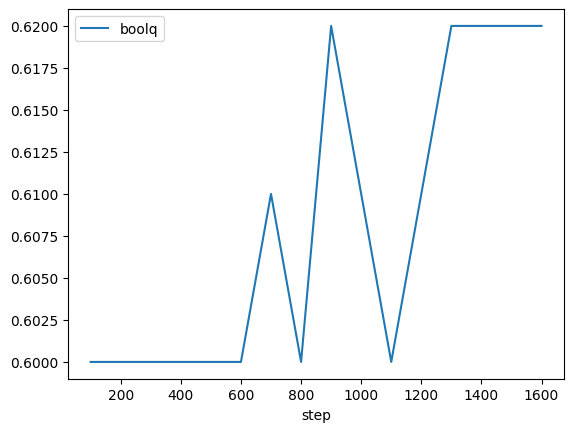

In [51]:
metrics_df[["step", "boolq"]].dropna().set_index("step").plot()

<Axes: xlabel='step'>

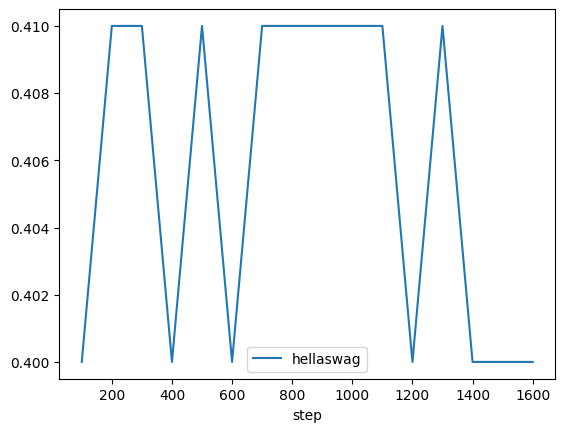

In [52]:
metrics_df[["step", "hellaswag"]].dropna().set_index("step").plot()

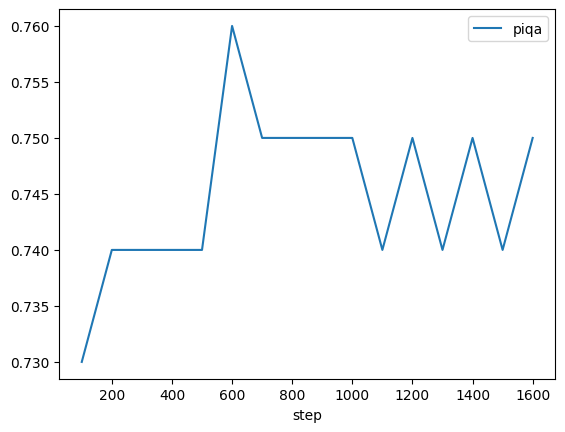

In [53]:
metrics_df = df[["step", "piqa"]].dropna().set_index("step").plot()

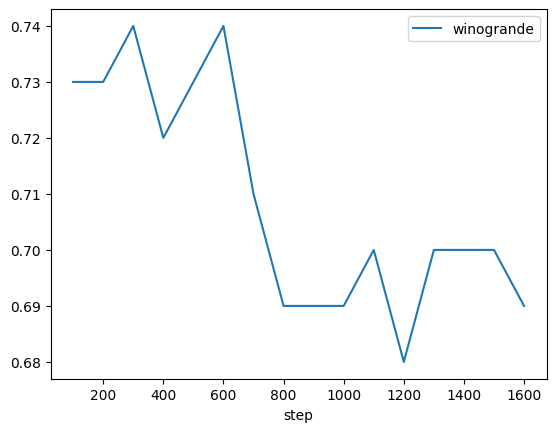

In [54]:
metrics_df = df[["step", "winogrande"]].dropna().set_index("step").plot()